# Développement d'un algorithme en Spark

# Objectif du Notebook
Il s'agit de développer en Spark une méthode de gradient, dans le but de résoudre un problème de filtrage collaboratif, et de la comparer avec une méthode de la librairie MLIB. Ce Notebook a pour but le développement et la validation de l'approche, avant intégration et exploitation dans le cadre de l'infrastructure développée dans le projet. Pour information, de nombreuses versions de ce problème existent sur le web.

# Position du problème
Nous avons à notre disposition un RDD "ratings" du type (userID, movieID, rating). Les données sont fournies par le fichier `ratings.dat`, stockées  au format ci-joint :
```
UserID::MovieID::Rating::Timestamp
```

Ce RDD peut être stocké dans une matrice $R$ où l'on trouve "rating" à l'intersection de la ligne "userID" et de la colonne "movieID".
Si la matrice $R$ est de taille $m \times  n$, nous cherchons $P \in R^{m,k}$ et $Q \in R^{n,k}$ telles que $R \approx \hat{R} = PQ^T$.
Pour cela on considère le problème
$$ \min_{P,Q} \sum_{i,j : r_{ij} \text{existe}}  \ell_{i,j}(R,P,Q), $$
où
$$  \ell_{i,j}(R,P,Q)= \left(r_{ij} - q_{j}^{\top}p_{i}\right)^2 + \lambda(|| p_{i} ||^{2}_2 + || q_{j} ||^2_2 )  $$ et $(p_i)_{1\leq i\leq m}$ et $(q_j)_{1\leq j\leq n}$ sont les lignes des matrices $P$ et $Q$ respectivement. Le paramètre $\lambda\geq 0$ est un paramètre de régularisation.

Le problème que nous résolvons ici est un problème dit de "filtrage collaboratif", qui permet d'apporter une solution possible du  problème Netflix. Les données sont issues de la base de données  "The MoviLens Datasets" :

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19


In [ ]:
# Librairies
import numpy as np
from scipy import sparse

# Environnement Spark 
# Librairies
import numpy as np
from scipy import sparse

# Environnement Spark 
#!apt-get update
#!apt-get install openjdk-8-jdk-headless
#!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
#!tar xf spark-2.4.7-bin-hadoop2.7.tgz

!pip install -q pyspark

from pyspark import SparkContext, SparkConf
import pyspark

     |████████████████████████████████| 204.2MB 62kB/s 
     |████████████████████████████████| 204kB 46.6MB/s 


In [ ]:

# A modifier/commenter selon votre configuration.
import os
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3.6'

conf = SparkConf()
conf.setMaster("local[*]")
conf.setAppName("Matrix Factorization")

sc = SparkContext(conf = conf)


In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/data/

gen_ratings.py	ratings.dat  README


#### Création du RDD et premières statistiques sur le jeu de données.

In [ ]:
# Répertoire contenant le jeu de données
#chemin Emma "/content/drive/MyDrive/Colab\ Notebooks/ratings.dat"
# chemin Kit "/content/drive/MyDrive/data/ratings.dat"

# ratings est un RDD du type (userID, movieID, rating)
def parseRating(line):
    fields = line.split('::')
    return int(fields[0]), int(fields[1]), float(fields[2])

ratingsRDD = sc.textFile("ratings.dat").map(parseRating).setName("ratings").cache()

In [ ]:
# Calcul du nombre de ratings
numRatings = ratingsRDD.count()
# Calcul du nombre d'utilisateurs distincts
numUsers = ratingsRDD.map(lambda r: r[0]).distinct().count()
# Calcul du nombre de films distincts
numMovies = ratingsRDD.map(lambda r: r[1]).distinct().count()
print("We have %d ratings from %d users on %d movies.\n" % (numRatings, numUsers, numMovies))

# Dimensions de la matrice R
M = ratingsRDD.map(lambda r: r[0]).max()
N = ratingsRDD.map(lambda r: r[1]).max()
matrixSparsity = float(numRatings)/float(M*N)
print("We have %d users, %d movies and the rating matrix has %f percent of non-zero value.\n" % (M, N, 100*matrixSparsity))

We have 1000209 ratings from 6040 users on 3706 movies.

We have 6040 users, 3952 movies and the rating matrix has 4.190221 percent of non-zero value.



Nous allons utiliser la routine ALS.train() de la librairie  [MLLib](http://spark.apache.org/docs/latest/ml-guide.html) et en évaluer la performance par un calcul de " Mean Squared Error" du  rating de prédiction.

__Question 1__

> Commenter les lignes de code suivantes en vous inspirant du code python http://spark.apache.org/docs/latest/mllib-collaborative-filtering.html#collaborative-filtering



In [ ]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.mllib.evaluation import RegressionMetrics

# Construction du modèle de recommendations depuis l'approche "Alternating Least Squares"
rank = 10
numIterations = 10

# Paramètres de la méthode Alternating Least Squares (ALS)
# ratings – RDD de Rating ou tuple (userID, productID, rating).
# rank – Rang de la matrice modèle.
# iterations – Nombre d'itérations. (default: 5)
# lambda_ – Paramètre de régularisation. (default: 0.01)
model = ALS.train(ratingsRDD, rank, iterations=numIterations, lambda_=0.02)


# Evaluation du modèle sur le jeu de données complet
testdata = ratingsRDD.map(lambda p: (p[0], p[1])) #on selectione les users et films sans les notes attribuées 
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2])) #on obtient un RDD avec les notes prédites par le modèle ALS
ratesAndPreds = ratingsRDD.map(lambda r: ((r[0], r[1]), r[2])).join(predictions) #jointure en un RDD tel que ((users,movies),(notespredites,notesattribuées))
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean() #mse calcule donc (notespredites-notesattribuées)^2
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.5861271603418868


#  Algorithmes de descente de gradient

Le but de cette section est  
1. de calculer le gradient de la fonction,
2. d'implémenter une méthode de gradient,
3. de mesurer la précision de cette méthode

__Question 2__

> Séparer le jeu de données en un jeu d'apprentissage (70%) et un jeu de test, en utilisant la fonction randomsplit ( http://spark.apache.org/docs/2.0.0/api/python/pyspark.html )

> Compléter la routine ci-dessous qui retourne le "rating" prédit. Créer un RDD contenant `(i,j,true rating,predicted rating)`. 

> Compléter la routine qui calcule le Mean Square Error (MSE) sur le jeu de données.

> Tester ensuite la routine de MSE en vous donnant les matrices $P$ et $Q$ aléatoires (utiliser np.random.rand(M,K)) et calculer quelques "ratings" prédits. 



In [ ]:
# Séparation du jeu de données en un jeu d'apprentissage et un jeu de test
# Taille du jeu d'apprentissage (en %) 
learningWeight = 0.7
# TO DO
# Création des RDD "apprentissage" et "test" depuis la fonction randomsplit

trainRDD,testRDD=ratingsRDD.randomSplit([learningWeight,1-learningWeight])

# Calcul du rating prédit.
def predictedRating(x, P, Q):
    """ 
    This function computes predicted rating
    Args:
        x: tuple (UserID, MovieID, Rating)
        P: user's features matrix (M by K)
        Q: item's features matrix (N by K)
    Returns:
        predicted rating: l
    """

    #### TO DOfirssd
    userID=x[0]
    movieID=x[1]
    PP=P[userID-1,:]  # On extrait la ligne correspondant aux caractéristiques de l'user d'ID userID de x
    QQ=Q[movieID-1,:] # On extrait la ligne correspondant au film d'ID movieID de x
    predictedrate=np.dot(PP,QQ) #On fait le produit scalaire qui vaut la note prédite
    return predictedrate


# Calcul de l'erreur MSE 
def computeMSE(rdd, P, Q):
    """ 
    This function computes Mean Square Error (MSE)
    Args:
        rdd: RDD(UserID, MovieID, Rating)
        P: user's features matrix (M by K)
        Q: item's features matrix (N by K)
    Returns:
        mse: mean square error 
    """ 
    ##### TO DO
    predictions2 = rdd.map(lambda r: ((r[0], r[1]), (r[2], predictedRating(r,P,Q))))
    mse = predictions2.map(lambda r: (r[1][0] - r[1][1])**2).mean()
    return mse

In [ ]:
# Tailles des jeux de données d'apprentissage et de tests.
print("Size of the training dataset:", trainRDD.count())
print("Size of the testing dataset:", testRDD.count())


# Création de matrices aléatoires de dimension (M,K) et (N,K)
K = 20 

# TO DO

M = ratingsRDD.map(lambda r: r[0]).max()
N = ratingsRDD.map(lambda r: r[1]).max()
P=np.random.rand(M,K)
Q=np.random.rand(N,K)

#Création du RDD contenant (i,j,true rating,predicted rating).

newRDDpred=ratingsRDD.map(lambda r: (r[0], r[1], r[2], predictedRating(r,P,Q)))

# Calcul et affichage de l'erreur MSE pour ces matrices aléatoires
#### TO DO
MSE=computeMSE(trainRDD,P,Q)
print("le MSE est de",MSE )

# Affichage de quelques ratings prédits depuis ces matrices
#### TO DO
print("((userID, movieID, rating), ratingpredicted)")
NB=5            #Nombre de rating qu'on souhaite afficher 
for i in range(NB): 
  print((trainRDD.take(NB)[i],predictedRating(trainRDD.take(NB)[i],P,Q)))


Size of the training dataset: 701049
Size of the testing dataset: 299160
le MSE est de 4.252717750222826
((userID, movieID, rating), ratingpredicted)
((1, 1193, 5.0), 4.720388501300859)
((1, 661, 3.0), 3.750005467680315)
((1, 914, 3.0), 4.202686036303896)
((1, 3408, 4.0), 3.8956734574771397)
((1, 1197, 3.0), 3.8387613154188336)


__Question 3__

> Donner la formule des dérivées des fonctions $\ell_{i,j}$ selon $p_t$ et $q_s$ avec $1\leq t\leq m$ et $1\leq s\leq n$.

> Commenter et compléter l'implantation de l'algorithme de gradient sur l'ensemble d'apprentissage. Prendre un pas égal à $\gamma=0.001$ et arrêter sur un nombre maximum d'itérations. 

> Commenter les tracés de convergence et des indicateurs de qualité de la prévision en fonction de la dimension latente (rang de $P$ et $Q$).

**Formules des dérivées :**
(calculées à partir de la définition de la dérivée)

Δpl(r, p,q) = 2 λ p - 2 r q + 2 q <p,q>
 
Δql(r, p,q) = 2 λ q - 2 r p + 2 p <p,q>

In [ ]:
# Algorithem de descente de gradient pour la factorisation de matrices
def GD(trainRDD, K=10, MAXITER=50, GAMMA=0.001, LAMBDA=0.05):
    # Construction de la matrice R (creuse)
    row=[]
    col=[]
    data=[]
    for part in trainRDD.collect():
        row.append(part[0]-1)
        col.append(part[1]-1)
        data.append(part[2])
    R=sparse.csr_matrix((data, (row, col))) #création de la matrice creuse tel que la note du user i sur le film j soit aux coordonées (i,j)
    
    # Initialisation aléatoire des matrices P et Q
    M,N = R.shape
    P = np.random.rand(M,K)
    Q = np.random.rand(N,K)
    
    # Calcul de l'erreur MSE initiale
    mse=[]
    mse_tmp = computeMSE(trainRDD, P, Q) #calcul du MSE avec P et Q aléatoires et non optimisés
    mse.append([0, mse_tmp])
    print("epoch: ", str(0), " - MSE: ", str(mse_tmp))
    
    # Boucle
    nonzero = R.nonzero() #liste les indices des notes attribuées sous la forme ([indices des x], [indices des y])
    nbNonZero = R.nonzero()[0].size #calcul du nombre de notes attribuées
    I,J = nonzero[0], nonzero[1] #récupération des indices sous deux listes 
    for epoch in range(MAXITER): #boucle qui représente le nombre d'itération de la descente de gradient 
        for i,j in zip(I,J): #boucle correspondant aux modifications de chaque ligne des matrices P et Q
          # Mise à jour de P[i,:] et Q[j,:] par descente de gradient à pas fixe
          #### TO DO
          #Δpl(r, p,q)=2 λ p - 2 r q + 2 q <p,q>
          #Δql(r, p,q)=2 λ q - 2 r p + 2 p <p,q>
          deltapL = 2*LAMBDA*P[i,:] - 2*R[i,j]*Q[j,:] + 2*Q[j,:]*np.dot(P[i,:],Q[j,:])
          deltaqL = 2*LAMBDA*Q[j,:] - 2*R[i,j]*P[i,:] + 2*P[i,:]*np.dot(P[i,:],Q[j,:])
          P[i,:] = P[i,:]-GAMMA*deltapL
          Q[j,:] = Q[j,:]-GAMMA*deltaqL

        # Calcul de l'erreur MSE courante, et sauvegarde dans le tableau mse 
        #### TO DO
        valeurmse = computeMSE(trainRDD, P, Q)
        mse.append([epoch+1, valeurmse])
        print("epoch: ", epoch+1, " - MSE: ", str(valeurmse))
    return P, Q, mse

In [ ]:
# Calcul de P, Q et de la mse
P,Q,mse = GD(trainRDD, K=10, MAXITER=10, GAMMA=0.001, LAMBDA=0.05)

epoch:  0  - MSE:  2.9098211886584093
epoch:  1  - MSE:  1.0274107941318649
epoch:  2  - MSE:  0.8987779992340345
epoch:  3  - MSE:  0.8634994477689986
epoch:  4  - MSE:  0.845740237933141
epoch:  5  - MSE:  0.8349615578262318
epoch:  6  - MSE:  0.8277415861811318
epoch:  7  - MSE:  0.822580292779876
epoch:  8  - MSE:  0.8187061101180527
epoch:  9  - MSE:  0.8156800730225272
epoch:  10  - MSE:  0.8132341321344188


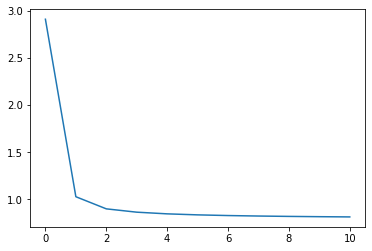

In [ ]:
import matplotlib.pyplot as plt 

# Affichage de l'erreur MSE
#### TO DO
x=[]
y=[]
for i in range(len(mse)): 
  x.append(mse[i][0])
  y.append(mse[i][1])
plt.plot(x,y)

__Question 4__

> Calculer les ratings prédits par la solution de la méthode du gradient dans un RDD

> Comparer sur le jeu de test les valeurs prédites aux ratings sur 5 échantillons aléatoires.

In [ ]:
# Calcul et affichage des ratings prédits
#### TO DO
#P et Q sont les nouvelles matrices issues de la méthode du gradient
ratingGrad=ratingsRDD.map(lambda r: ((r[0], r[1]), (r[2], predictedRating(r,P,Q))))


NB=5            #Nombre de rating qu'on souhaite afficher 
x=np.random.randint(numRatings,size=NB) # on génère 5 nombres aléatoires entre 0 et numRatings
grad=[] #prédiction par la méthode de descente de gradient 
als=[]  #prédiction par la méthode ALS
#for i in x: 
 # print("grad",(ratingGrad.take(max(x)+1)[i]))
  #print("als",(predictions.take(max(x)+1)[i]))
  #grad.append(ratingGrad.take(max(x)+1)[i])
  #als.append(predictions.take(max(x)+1)[i])


for i in x: 
  als.append(ratesAndPreds.take(max(x)+1)[i])

for k in range(len(als)):
  grad.append((als[k][0],predictedRating(als[k][0],P,Q)))



In [ ]:
#print("((userID, movieID, rating), ratingpredicted)")
#print(als)
#print(grad)
for j in range(len(als)):
  print("pour le couple", als[j][0], "la note donnée est ",als[j][1][0],"l'estimation avec la méthode gradient",grad[j][1],"avec la méthode als", als[j][1][1])


pour le couple (5795, 955) la note donnée est  4.0 l'estimation avec la méthode gradient 3.842141840719003 avec la méthode als 4.537545200066474
pour le couple (2116, 1198) la note donnée est  4.0 l'estimation avec la méthode gradient 4.831802741245416 avec la méthode als 4.533166903632617
pour le couple (1168, 2395) la note donnée est  4.0 l'estimation avec la méthode gradient 3.7036159701197446 avec la méthode als 3.8252234708366393
pour le couple (5683, 1197) la note donnée est  4.0 l'estimation avec la méthode gradient 4.542558851273726 avec la méthode als 3.7555868719424805
pour le couple (1449, 1713) la note donnée est  3.0 l'estimation avec la méthode gradient 2.480432559111568 avec la méthode als 2.599031191798435


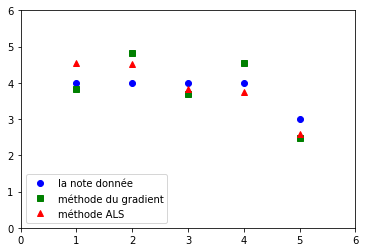

In [ ]:
Ygived=[]
Ygrad=[]
Yals=[]
X=[]
for j in range(NB):
  X.append(j+1)
  Ygived.append(als[j][1][0])
  Ygrad.append(grad[j][1])
  Yals.append(als[j][1][1])

plt.plot(X,Ygived,'bo',label='la note donnée')
plt.plot(X,Ygrad,'gs', label ='méthode du gradient')
plt.plot(X,Yals,'r^',label ='méthode ALS')
axes = plt.gca()
axes.set_xlim(0, 6) 
axes.set_ylim(0, 6) 
plt.legend()
#la note donnée est représentée en  ronds bleu
#la note obtenue par la méthode du gradient est représentée en carrés vert
#la note obtenue par la méthode ALS est représentée en triangles rouges

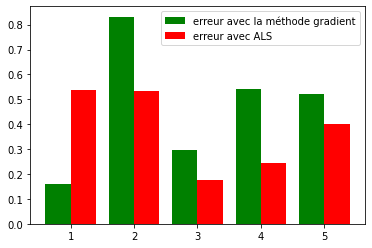

In [ ]:
erreurGrad = [abs(Delt - Gelt) for Delt, Gelt in zip(Ygived,Ygrad)]
erreurALS = [abs(Delt - Aelt) for Delt, Aelt in zip(Ygived,Yals)]
barWidth = 0.4
gg = range(len(erreurGrad))
aa = [x + barWidth for x in gg]

plt.bar(gg, erreurGrad, width = barWidth, color = ['green' for i in erreurGrad],label='erreur avec la méthode gradient')
plt.bar(aa, erreurALS, width = barWidth, color = ['red' for i in erreurALS], label='erreur avec ALS')
plt.xticks([r + barWidth / 2 for r in range(len(erreurGrad))], ['1', '2', '3', '4','5'])
plt.legend()